# 🌲 Capítulo 6 – Detección de Anomalías con Isolation Forest

En el quinto capítulo se presentará el algoritmo Isolation Forest, una técnica no supervisada de detección de anomalías que se fundamenta en principios estadísticos y estructurales. Su principal fortaleza radica en que no requiere datos etiquetados ni un entrenamiento supervisado, lo que lo convierte en una opción idónea para contextos como el presente, donde no se dispone de información fiable que distinga entre observaciones normales y anómalas.

Isolation Forest se basa en la idea de que los puntos anómalos, al estar menos integrados en la distribución general de los datos, pueden aislarse más fácilmente a través de divisiones aleatorias del espacio de características. 

---

## 🎯 ¿Por qué Isolation Forest?

La elección de Isolation Forest para la detección de anomalías responde a varios motivos:

- Es un modelo **ligero, interpretable y rápido de entrenar**, ideal para exploración temprana.
- No necesita etiquetas ni conocimiento experto previo.
- Puede aplicarse directamente sobre datos multivariados sin requerir grandes transformaciones.
- Ha sido ampliamente utilizado en entornos industriales y de ingeniería de sistemas, lo que aporta cierta confianza sobre su aplicabilidad.

---

## 🧭 Objetivo de este capítulo

A lo largo del capítulo se presentarán:

- Los fundamentos teóricos de Isolation Forest.
- Su aplicación sobre datos reales extraídos de archivos MDF.
- Dos variantes distintas del modelo, incluyendo ajustes en los métodos de partición.
- Un análisis cualitativo de los resultados y sus limitaciones.

Además, se plantearán estrategias para enriquecer la entrada del modelo con información contextual (como deltas y aceleraciones), y se discutirán sus efectos en la detección.

El capítulo concluirá con una reflexión sobre lo que Isolation Forest puede —y no puede— aportar en un contexto como este, y se introducirá el enfoque del siguiente capítulo: **modelos ocultos de Markov (HMM)** para modelar dependencias temporales.

---

## 🔍 Intuición

Isolation Forest (iForest) se basa en la premisa de que:

> "Las anomalías son más fáciles de aislar que los puntos normales."

A diferencia de otros métodos que perfilan el comportamiento normal de los datos, iForest **aísla los puntos** de forma aleatoria y mide cuán fácil es hacerlo. Las anomalías, al ser menos frecuentes y más distintas, se aíslan en menos pasos.

---

## 🧠 Fundamento Teórico

Isolation Forest construye múltiples **árboles binarios aleatorios** (llamados *iTrees*), donde:

- En cada nodo, se selecciona aleatoriamente:
  - Una característica (feature).
  - Un valor de corte entre el mínimo y máximo de esa característica.
- El árbol se construye **recursivamente** hasta:
  - Aislar un único punto, o
  - Alcanzar una profundidad máxima predefinida.

---

## 📐 Profundidad de Aislamiento

Cada punto es recorrido por todos los árboles. Se mide la **longitud del camino** (profundidad) que se necesita para aislarlo.

- Las **anomalías** se aíslan rápidamente → profundidad baja.
- Los **puntos normales** requieren más divisiones → profundidad alta.

La **profundidad media esperada** $ E(h(x)) $ sobre todos los árboles se convierte en un **score de anomalía**:


$$s(x, n) = 2^{-\frac{E(h(x))}{c(n)}}$$


Donde:

- $ s(x, n) \in [0, 1] $: Score de anomalía.
- $ E(h(x)) $: Profundidad media de aislamiento para el punto $ x $.
- $ c(n) $: Valor esperado de la profundidad promedio en un árbol aleatorio para $ n $ puntos:


$$c(n) = 2H(n - 1) - \frac{2(n - 1)}{n}$$


y $ H(i) $ es el $ i $-ésimo número armónico.

---

## 📊 Interpretación del Score

| Score $ s(x) $ | Interpretación            |
|------------------|----------------------------|
| ≈ 1              | Alta probabilidad de anomalía |
| ≈ 0.5            | Indefinido                 |
| ≈ 0              | Punto normal               |

---

## ⚙️ Parámetros Clave

- **n_estimators**: Número de árboles a construir (típico: 100–256).
- **max_samples**: Número de muestras para construir cada árbol (puede ser una fracción del total).
- **max_depth**: Profundidad máxima del árbol (normalmente log₂(n)).
- **Contamination** (en implementación práctica): Porcentaje estimado de anomalías, usado para establecer un umbral.

---

## ✅ Ventajas

- Eficiente en datasets grandes y de alta dimensión.
- No requiere suposiciones estadísticas sobre los datos.
- No supervisado (no necesita etiquetas).

---

## 🚫 Limitaciones

- El rendimiento puede depender de una buena selección de `max_samples`.
- No captura bien estructuras temporales si no se adaptan las features.
- **Cuando se aplica directamente sobre datos crudos, solo detecta anomalías basadas en valores atípicos individuales o combinaciones inusuales. No suele detectar anomalías que provienen de relaciones anómalas entre variables.**

---

### 🔧 Ejemplo concreto

Supongamos un motor en condiciones normales del que poseemos datos de un rodaje en un llano:

- Cuando las **revoluciones por minuto (RPM)** son bajas (ej. 100 RPM), la **temperatura del refrigerante** también debería ser baja (ej. 40 °C).

Si aparece un punto con:

- RPM = 100  
- Temperatura = 95 °C  

Esta combinación **viola la lógica física esperada**, pero los valores individuales **no son extremos**. Si hay otros puntos similares en el dataset, el algoritmo podría **no detectarlo como anómalo**, porque **estadísticamente no es raro**.

➡️ **Isolation Forest no detecta por sí solo rupturas de relaciones físicas entre variables, a menos que esas combinaciones sean infrecuentes en los datos.**

---

## 🔗 Referencias

Liu, Fei Tony, Kai Ming Ting, and Zhi-Hua Zhou.  
**"Isolation forest."** 2008 Eighth IEEE International Conference on Data Mining. IEEE, 2008.




## Análisis de señales sintéticas para detección de anomalías

En esta sección trabajaremos con un **dataset sintético generado específicamente para la explicación y demostración de modelos de detección de anomalías**.  

El dataset contiene **tres señales distintas pero relacionadas entre sí**, diseñadas para reflejar dinámicas variadas y al mismo tiempo mantener cierta correlación. Esto nos permite ilustrar el funcionamiento de los algoritmos en un entorno controlado y reproducible, sin depender de etiquetas externas.  

Las señales incluidas son:

- **f1**: onda sinusoidal con ruido, que aporta una dinámica periódica y suave.  
- **f2**: onda cuadrada con ruido, de cambios bruscos y alternancia marcada.  
- **f3**: un proceso aleatorio acumulado (*random walk*), que muestra un comportamiento errático y distinto de las anteriores.  

Sobre estas señales se han inyectado anomalías de manera **aleatoria en forma, intensidad, duración y señales afectadas**, lo que genera escenarios más realistas. Entre los tipos de anomalías posibles se incluyen:  

- **Picos aislados** de distinta magnitud.  
- **Derivas temporales (drift)** con pendientes y duraciones variables.  
- **Tramos planos (flat)** en valor cero o mantenidos artificialmente.  
- **Ruido anómalo** de alta intensidad en segmentos cortos.  

Este diseño permite observar cómo un mismo algoritmo puede reaccionar ante anomalías muy diferentes, lo que resulta útil para entender mejor sus fortalezas y limitaciones.  

A continuación se podrán ver las señales.


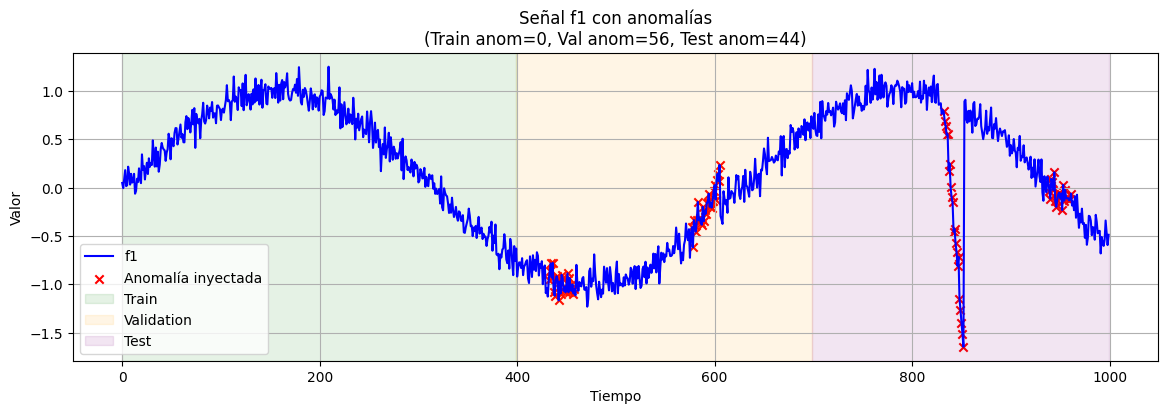

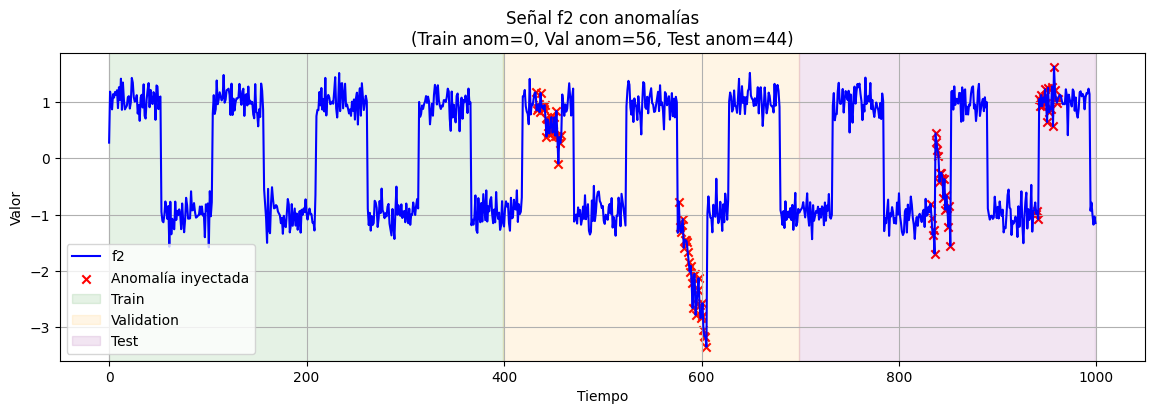

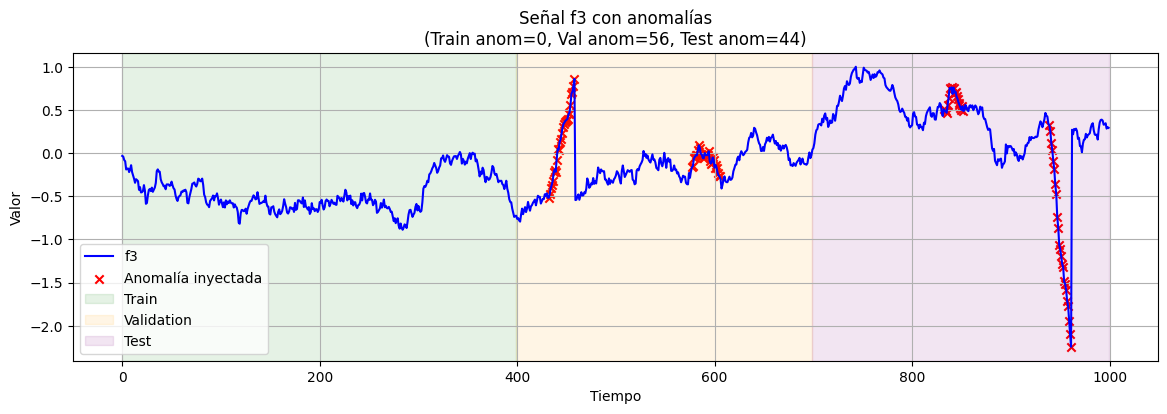

In [30]:
import matplotlib.pyplot as plt
import pandas as pd
from utils import generate_synthetic_timeseries

train_df, val_df, test_df = generate_synthetic_timeseries(
    n=1000,
    train_ratio=0.4,
    val_ratio=0.3,
    anomaly_ratio=0.007,
    seed=42
)

# Concatenar
full_df = pd.concat([train_df, val_df, test_df], ignore_index=True)

# Límites de los splits
train_end = train_df["timestamp"].max()
val_end = val_df["timestamp"].max()

# Visualización
for col in ["f1", "f2", "f3"]:
    fig, ax = plt.subplots(figsize=(14, 4))
    ax.plot(full_df["timestamp"], full_df[col], label=f"{col}", color="blue")

    # Anomalías
    anomaly_idx = full_df[full_df["anomaly"] == 1].index
    ax.scatter(full_df.loc[anomaly_idx, "timestamp"],
               full_df.loc[anomaly_idx, col],
               color="red", marker="x", label="Anomalía inyectada")

    # Fondos para train / val / test
    ax.axvspan(full_df["timestamp"].min(), train_end, alpha=0.1, color="green", label="Train")
    ax.axvspan(train_end, val_end, alpha=0.1, color="orange", label="Validation")
    ax.axvspan(val_end, full_df["timestamp"].max(), alpha=0.1, color="purple", label="Test")

    ax.set_title(
        f"Señal {col} con anomalías\n"
        f"(Train anom={train_df['anomaly'].sum()}, "
        f"Val anom={val_df['anomaly'].sum()}, "
        f"Test anom={test_df['anomaly'].sum()})"
    )
    ax.set_xlabel("Tiempo")
    ax.set_ylabel("Valor")
    ax.legend()
    ax.grid(True)
    plt.show()


## 🧪 Prueba adicional: enriquecer el modelo con dinámica temporal

Como prueba complementaria, se explorará la posibilidad de que Isolation Forest pueda captar **comportamientos más ricos que simples valores puntuales**, incorporando información sobre la dinámica del sistema.

Para ello, se enriquecerá el conjunto de datos añadiendo:

- **Deltas (primera derivada):** cambios entre un instante y el anterior.
- **Aceleración (segunda derivada):** cambios en la velocidad de variación.

Estas variables adicionales permiten describir no solo *en qué estado está el sistema*, sino también *cómo está evolucionando*. De este modo, se busca que el algoritmo tenga una representación más completa del contexto de cada observación, aumentando así su capacidad para detectar anomalías que no sean necesariamente extremos absolutos, sino comportamientos inusuales en la evolución de las señales.

Los datos enriquecidos serán utilizados como entrada del modelo, manteniendo el mismo procedimiento de detección con Isolation Forest.